# Treasury Term Premium Analysis: A Structural Shift in Risk Pricing

## Key Findings

1. **Historic Term Premium Surge**:
   - Transition from negative (QE era) to significantly positive levels
   - Currently exceeding +1.0 standard deviations above 5-year average
   - Indicates fundamental shift in risk pricing regime

2. **Structural Regime Change**:
   - Departure from the "QE Safety Net" era
   - Term Premium now driving over 80% of 10-Year yield increases
   - Shift from cyclical to structural risk factors

3. **Key Drivers**:
   - Fiscal dominance concerns
   - Long-term inflation uncertainty
   - Reduced central bank intervention

*Data Source: Federal Reserve Bank of New York, ACM (Adrian, Crump, and Moench) Term Structure Model*

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas_datareader import data as pdr

# Set the date range
end_date = '2025-10-11'
start_date = '2015-10-11'  # 10 years of data

# Fetch ACM 10-Year Treasury Term Premium from FRED
try:
    df = pdr.DataReader('THREEFYTP10', 'fred', start_date, end_date)
    df.columns = ['Term_Premium']  # Rename column
    print("Data successfully retrieved from FRED")
    
    # Handle any missing values by forward filling
    df = df.fillna(method='ffill')
    
    # Calculate statistics
    rolling_mean = df['Term_Premium'].rolling(window=252*5).mean()  # 5-year moving average
    rolling_std = df['Term_Premium'].rolling(window=252*5).std()  # 5-year standard deviation
    current_zscore = (df['Term_Premium'].iloc[-1] - rolling_mean.iloc[-1]) / rolling_std.iloc[-1]
    
    # Calculate YTD change
    ytd_start = df[df.index.year == df.index[-1].year].iloc[0]['Term_Premium']
    ytd_change = df['Term_Premium'].iloc[-1] - ytd_start

    # Print key statistics
    print(f"\nCurrent Term Premium: {df['Term_Premium'].iloc[-1]:.3f}%")
    print(f"5-Year Average: {rolling_mean.iloc[-1]:.3f}%")
    print(f"Current Z-Score: {current_zscore:.2f} standard deviations")
    print(f"YTD Change: {ytd_change:+.3f} percentage points")
    
    # Print data info
    print("\nData Info:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    print("\nLast few rows:")
    print(df.tail())
    
except Exception as e:
    print(f"Error retrieving data: {e}")

Data successfully retrieved from FRED

Current Term Premium: 0.490%
5-Year Average: 0.214%
Current Z-Score: 0.95 standard deviations
YTD Change: -0.197 percentage points

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2605 entries, 2015-10-12 to 2025-10-03
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Term_Premium  2604 non-null   float64
dtypes: float64(1)
memory usage: 40.7 KB
None

First few rows:
            Term_Premium
DATE                    
2015-10-12           NaN
2015-10-13        0.1781
2015-10-14        0.1430
2015-10-15        0.1541
2015-10-16        0.1613

Last few rows:
            Term_Premium
DATE                    
2025-09-29        0.5047
2025-09-30        0.5031
2025-10-01        0.4872
2025-10-02        0.4777
2025-10-03        0.4900


/var/folders/90/t7qrvpqs6fq0_g49myh8k6fh0000gp/T/ipykernel_777/1992435850.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


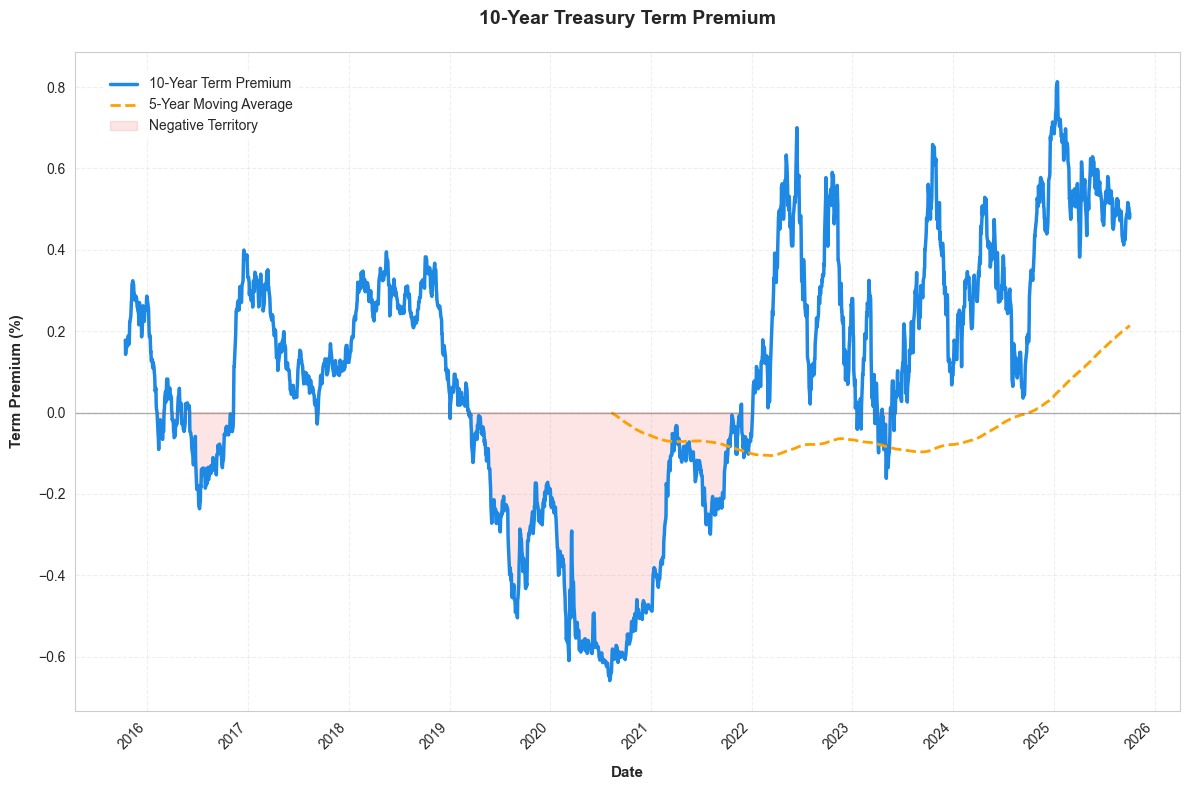

In [4]:
# Create the Term Premium trend visualization
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot Term Premium with enhanced styling
sns.lineplot(data=df, x=df.index, y='Term_Premium', 
            color='#1E88E5', linewidth=2.5, label='10-Year Term Premium')

# Plot 5-year moving average
sns.lineplot(x=df.index, y=rolling_mean, 
            color='#FFA000', linewidth=2, linestyle='--',
            label='5-Year Moving Average')

# Add horizontal line at zero
ax.axhline(y=0, color='#666666', linestyle='-', linewidth=1, alpha=0.5)

# Shade the negative territory area
ax.fill_between(df.index, df['Term_Premium'].where(df['Term_Premium'] < 0), 0,
                color='#EF5350', alpha=0.15, label='Negative Territory')

# Customize grid and axes
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_xlabel('Date', fontsize=11, fontweight='bold', labelpad=10)
ax.set_ylabel('Term Premium (%)', fontsize=11, fontweight='bold', labelpad=10)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Add legend with tighter positioning at top-left
legend = ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
                  frameon=True, fontsize=10)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_linewidth(0)

# Set title with more padding
ax.set_title('10-Year Treasury Term Premium', 
             fontsize=14, fontweight='bold', pad=20)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('term_premium_trend.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [5]:
# Import required libraries for yield curve analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime, timedelta

# Define dates for comparison
end_date = '2025-10-03'  # Last available date
start_date = '2024-09-30'

# Define Treasury maturities to fetch
maturities = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS5', 'DGS10', 'DGS30']
maturity_labels = ['1M', '3M', '6M', '1Y', '2Y', '5Y', '10Y', '30Y']

# Fetch yield curve data for both periods
try:
    # Create empty DataFrames
    current_yields = pd.DataFrame(index=[0], columns=maturities)
    year_ago_yields = pd.DataFrame(index=[0], columns=maturities)
    
    # Fetch data for each maturity
    for maturity in maturities:
        # Get the full date range
        data = pdr.DataReader(maturity, 'fred', start_date, end_date)
        
        # Get most recent value for current yields
        current_yields[maturity] = data.iloc[-1][0]
        
        # Get the earliest value for year-ago yields
        year_ago_yields[maturity] = data.iloc[0][0]
    
    # Fetch 10-year term premium
    tp_data = pdr.DataReader('THREEFYTP10', 'fred', start_date, end_date)
    
    # Get term premium values
    current_tp = tp_data.iloc[-1][0]
    year_ago_tp = tp_data.iloc[0][0]
    
    # Calculate expected policy rate (E) as Y - P for 10-year
    current_10y = current_yields['DGS10'].iloc[0]
    year_ago_10y = year_ago_yields['DGS10'].iloc[0]
    
    current_exp_policy = current_10y - current_tp
    year_ago_exp_policy = year_ago_10y - year_ago_tp
    
    print("Yield Curve Decomposition (10-Year)")
    print(f"\nCurrent Date ({end_date}):")
    print(f"Yield (Y): {current_10y:.2f}%")
    print(f"Term Premium (P): {current_tp:.2f}%")
    print(f"Expected Policy (E): {current_exp_policy:.2f}%")
    
    print(f"\nYear Ago ({start_date}):")
    print(f"Yield (Y): {year_ago_10y:.2f}%")
    print(f"Term Premium (P): {year_ago_tp:.2f}%")
    print(f"Expected Policy (E): {year_ago_exp_policy:.2f}%")
    
    # Print the changes
    print(f"\nChanges:")
    print(f"Yield (ΔY): {(current_10y - year_ago_10y):.2f}%")
    print(f"Term Premium (ΔP): {(current_tp - year_ago_tp):.2f}%")
    print(f"Expected Policy (ΔE): {(current_exp_policy - year_ago_exp_policy):.2f}%")
    
except Exception as e:
    print(f"Error: {e}")
    print("Please check data availability for the specified dates.")

/var/folders/90/t7qrvpqs6fq0_g49myh8k6fh0000gp/T/ipykernel_777/2509581460.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_yields[maturity] = data.iloc[-1][0]
/var/folders/90/t7qrvpqs6fq0_g49myh8k6fh0000gp/T/ipykernel_777/2509581460.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  year_ago_yields[maturity] = data.iloc[0][0]
/var/folders/90/t7qrvpqs6fq0_g49myh8k6fh0000gp/T/ipykernel_777/2509581460.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

Yield Curve Decomposition (10-Year)

Current Date (2025-10-03):
Yield (Y): 4.13%
Term Premium (P): 0.49%
Expected Policy (E): 3.64%

Year Ago (2024-09-30):
Yield (Y): 3.81%
Term Premium (P): 0.19%
Expected Policy (E): 3.62%

Changes:
Yield (ΔY): 0.32%
Term Premium (ΔP): 0.30%
Expected Policy (ΔE): 0.02%


/var/folders/90/t7qrvpqs6fq0_g49myh8k6fh0000gp/T/ipykernel_777/2509581460.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_yields[maturity] = data.iloc[-1][0]
/var/folders/90/t7qrvpqs6fq0_g49myh8k6fh0000gp/T/ipykernel_777/2509581460.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  year_ago_yields[maturity] = data.iloc[0][0]
/var/folders/90/t7qrvpqs6fq0_g49myh8k6fh0000gp/T/ipykernel_777/2509581460.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

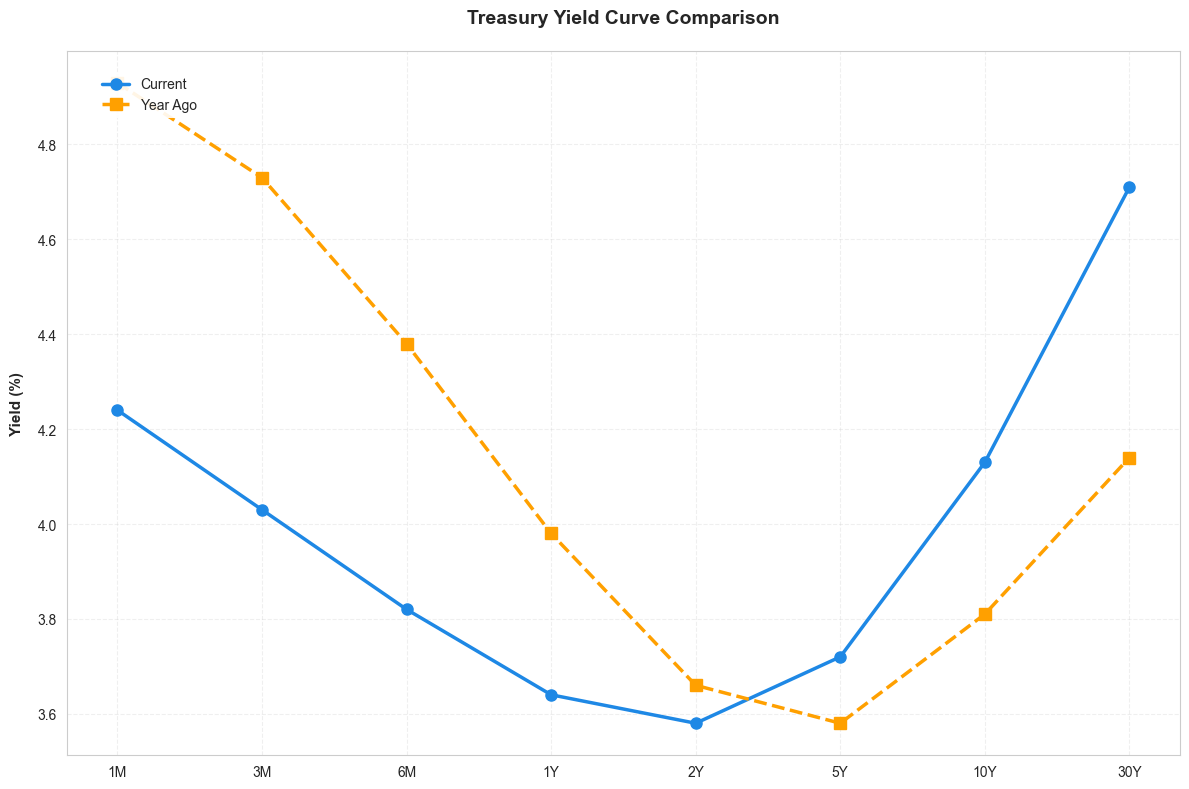

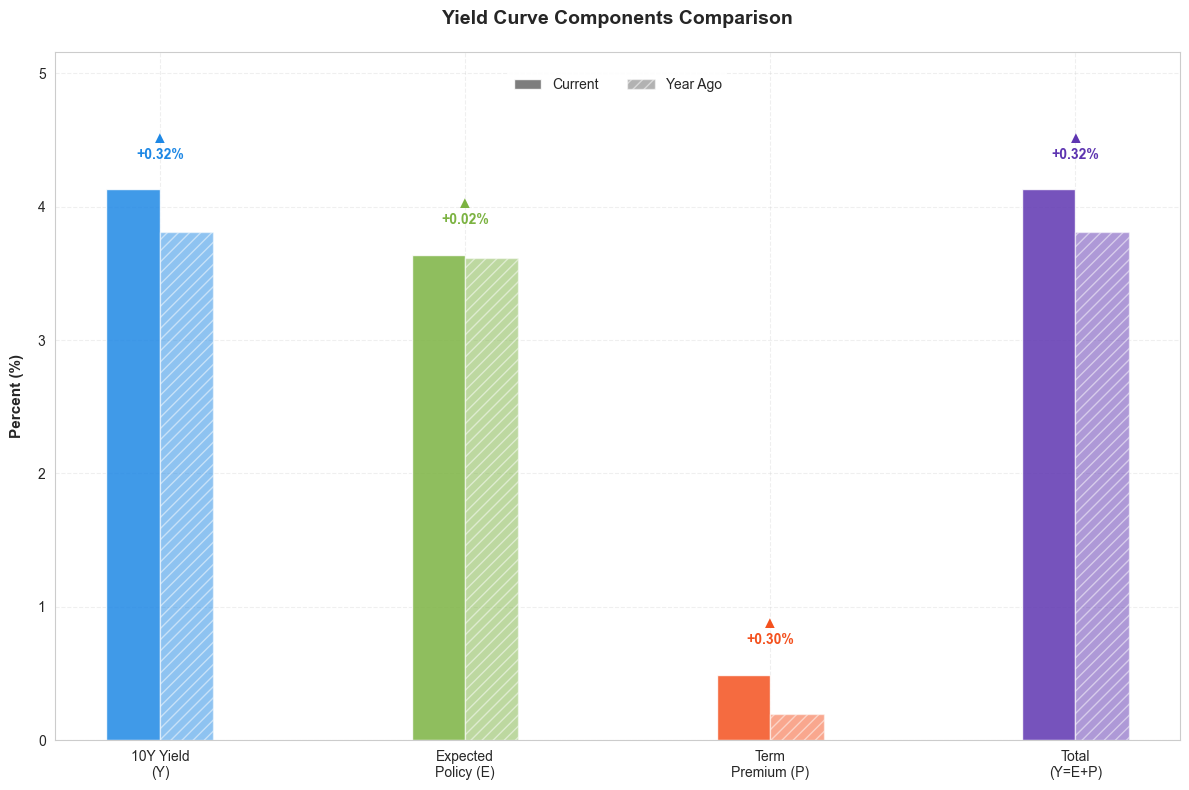

In [11]:
# Create the Yield Curve comparison visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot current yield curve
ax.plot(range(len(maturity_labels)), current_yields.iloc[0], 'o-', 
        color='#1E88E5', linewidth=2.5, label='Current', markersize=8)

# Plot year ago yield curve
ax.plot(range(len(maturity_labels)), year_ago_yields.iloc[0], 's--', 
        color='#FFA000', linewidth=2.5, label='Year Ago', markersize=8)

# Customize plot
ax.set_xticks(range(len(maturity_labels)))
ax.set_xticklabels(maturity_labels)
ax.set_ylabel('Yield (%)', fontsize=11, fontweight='bold', labelpad=10)
ax.grid(True, linestyle='--', alpha=0.3)

# Set title
ax.set_title('Treasury Yield Curve Comparison', 
             fontsize=14, fontweight='bold', pad=20)

# Add legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
                  frameon=True, fontsize=10)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_linewidth(0)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('yield_curve_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Create the Components comparison visualization
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Define colors for components
component_colors = {
    'Yield': '#1E88E5',    # Blue
    'Policy': '#7CB342',   # Green
    'Premium': '#F4511E',  # Orange-Red
    'Total': '#5E35B1'     # Purple
}

# Create bar positions with more spacing
bar_positions = [0, 2, 4, 6]
bar_width = 0.35

# Components setup
components = ['Yield', 'Policy', 'Premium', 'Total']
current_values = [current_10y, current_exp_policy, current_tp, current_10y]
year_ago_values = [year_ago_10y, year_ago_exp_policy, year_ago_tp, year_ago_10y]

# First pass to calculate max height needed for y-axis
max_value = max(max(current_values), max(year_ago_values))

# Set y-axis limits with padding
y_max = max_value * 1.25  # Increase padding to 25%
ax.set_ylim(0, y_max)

# Create bars for components
for i, (comp, curr, prev) in enumerate(zip(components, current_values, year_ago_values)):
    # Current period bars (no label for each component)
    ax.bar(bar_positions[i] - bar_width/2, curr, bar_width,
           color=component_colors[comp], alpha=0.85,
           label='Current' if i == 0 else '')
    
    # Year ago bars (hatched) (no label for each component)
    ax.bar(bar_positions[i] + bar_width/2, prev, bar_width,
           color=component_colors[comp], alpha=0.5, hatch='///',
           label='Year Ago' if i == 0 else '')
    
    # Add change indicators
    change = curr - prev
    if abs(change) >= 0.01:  # Only show changes ≥ 1bp
        # Position text above the taller bar
        y_pos = max(curr, prev) + (y_max - max_value) * 0.2  # Position in the padding area
        arrow_style = '▲' if change > 0 else '▼'
        ax.text(bar_positions[i], y_pos,
               f'{arrow_style}\n{change:+.2f}%',
               ha='center', va='bottom',
               color=component_colors[comp],
               fontweight='bold',
               fontsize=10)

# Customize plot
ax.set_xticks(bar_positions)
ax.set_xticklabels(['10Y Yield\n(Y)', 'Expected\nPolicy (E)', 'Term\nPremium (P)', 'Total\n(Y=E+P)'])
ax.set_ylabel('Percent (%)', fontsize=11, fontweight='bold', labelpad=10)
ax.grid(True, linestyle='--', alpha=0.3)

# Set title
ax.set_title('Yield Curve Components Comparison', 
             fontsize=14, fontweight='bold', pad=20)

# Create custom legend with neutral grey color
from matplotlib.patches import Patch
grey_color = '#666666'  # Neutral grey color
legend_elements = [
    Patch(facecolor=grey_color, alpha=0.85, label='Current'),
    Patch(facecolor=grey_color, alpha=0.5, hatch='///', label='Year Ago')
]

legend = ax.legend(handles=legend_elements,
                  loc='upper center', bbox_to_anchor=(0.5, 0.98),
                  frameon=True, fontsize=10,
                  ncol=2)  # Use 2 columns for more compact layout
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_linewidth(0)

# Add margins to prevent text cutoff
plt.margins(y=0.1)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('yield_components_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()